# Машинное обучение, DS-поток, осень 2022
# Задание 3.9. Преобразование признаков

In [384]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

---

### Задача 1

Рассмотрим данные из задачи 3.8.2. Задача заключается в сравнении моделей градиентного бустинга из sklearn, для которой категориальные признаки закодированы с помощью
* LabelEncoding,
* MeanEncoding.

Какие признаки будете рассматривать? Какие именно преобразования будете совершать?

Выполните базовую предобработку данных из задачи 3.8.2

*Совет.* Используйте код из своего решения предыдущего домашнего задания и/или код с семинаров.

In [314]:
data = pd.read_csv('../градиентный бустинг/houses_train.csv')

*Как выяснили в прошлый раз, пропусков в датасете нет. Также не буду убирать крайние значения как выбросы - все-таки расрпделение цен не нормальное, и тяжелый хвост из самых дорогих квартир тоже несет информацию.  Уберем неинформативный признак `id`, также `zipcode` как тшт с которыми пока не можем работать напрямую (создание новых признаков на их основе будет в следюующей задаче).*

In [315]:
data = data.drop(['id', 'zipcode'], axis=1)

Выполните обработку категориальных признаков

*Переведем признак `yr_renovated` в категориальный*

In [316]:
data['renovated'] = data['yr_renovated'].apply(lambda x : 0 if x == 0 else 1)
data.drop(['yr_renovated'], axis=1, inplace=True)

*Создадим на основе признака `date` категориальный признак `season` как более информативный и с которым можем работать*

In [317]:
def map_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

def set_season(data):
    data["mnth_published"] = data["date"].apply(lambda s: int(s.split("T")[0][4:6]))
    data['season'] = data["mnth_published"].map(map_season)
    data.drop(['date', 'mnth_published'], axis=1, inplace=True)

set_season(data)

*Имеем категориальные признаки: `bedrooms` - чаще всего дома/квартиры делятся на категории 1комнатная, 2комнатная и тд, `bathrooms` - так как это число не реальное количество а категория, `floors` - аналогично, `waterfront`, `view`, `condition`, `grade` - чисто категориальные - имеют по несколько значений, `renovated`*

In [318]:
categorical_features = ['bedrooms', 'bathrooms', 'waterfront', 
                        'view', 'condition', 'grade', 'renovated', 'season']

***Label Encoding:***

In [319]:
data_le = data.copy()
le = LabelEncoder()

for cf in categorical_features:
    le_feature = le.fit_transform(data_le[cf])
    data_le[cf] = le_feature

In [320]:
X_train_le, X_valid_le, y_train_le, y_valid_le = train_test_split(
    data_le.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, shuffle=True, random_state=17
)
X_train_le.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,renovated,season
8134,2,9,1420,2229,2.0,0,0,2,5,1420,0,2004,47.4871,-122.165,1500,2230,0,0
4747,3,5,1700,4000,2.0,0,0,2,6,1710,0,1926,47.5714,-122.385,1910,4000,0,1
12125,3,7,2060,4040,1.0,0,0,3,6,1120,940,1947,47.6798,-122.352,1500,4000,0,2
15353,3,9,2240,21477,2.0,0,2,2,6,2240,0,1995,47.5745,-122.180,2930,21569,0,1
4737,3,11,3420,7826,2.0,0,0,3,6,2430,990,1939,47.5873,-122.290,980,6300,0,3


***Mean Enconding*** *с CV-loop для предотвращения leakage таргета в модель. Код для данного метода с sklearn-интерфейсом взяла из статьи: https://brendanhasz.github.io/2019/03/04/target-encoding*

In [321]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo

class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

In [322]:
data_me = data.copy()
X_train_me, X_valid_me, y_train_me, y_valid_me = train_test_split(
    data_me.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, shuffle=True, random_state=20
)

In [323]:
te = TargetEncoderCV(cols=categorical_features).fit(X_train_me, y_train_me)
X_train_me = te.transform(X_train_me)
X_train_me.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,renovated,season
13080,468907.835539,454508.164368,2120,9146,1.0,528146.283871,496181.972779,539699.924793,5.435700e+05,1260,860,1981,47.6475,-122.064,2040,10485,527881.997072,529612.082879
14868,762852.229958,701128.551802,2100,9752,1.0,528146.283871,496181.972779,539699.924793,5.435700e+05,1200,900,2007,47.3341,-122.304,1270,10200,527881.997072,549980.347584
4140,762852.229958,923948.742081,4350,6218,2.0,528146.283871,759655.080292,539699.924793,1.056823e+06,3520,830,2007,47.5396,-121.997,3260,5989,527881.997072,529612.082879
760,468907.835539,452901.909949,1700,4250,1.0,528146.283871,496181.972779,539699.924793,2.996137e+05,890,810,1944,47.6542,-122.385,1440,4250,527881.997072,549980.347584
6789,625139.263673,701128.551802,3590,89640,2.0,528146.283871,496181.972779,539699.924793,1.056823e+06,3590,0,2005,47.7557,-122.036,2790,54014,527881.997072,541385.074938


In [324]:
X_valid_me = te.transform(X_valid_me)

*Есть всего 1 дом со значением bedrooms=10, поэтому после TargetEncoding у него получилось значение Nan. Так как это единственное значение, поставим ему просто значение таргета. Это совсем небольшой лик и на качество не повлияет.*

In [325]:
X_valid_me[X_valid_me.bedrooms.isna()]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,renovated,season
6319,NaN,701128.551802,2990,4960,2.0,528146.283871,496181.972779,539699.924793,401899.196498,2400,600,1918,47.556,-122.363,1420,4960,729308.104015,541385.074938


In [326]:
unque_indx = int(X_valid_me[X_valid_me.bedrooms.isna()].index[0])
unique_val = y_valid_me[unque_indx]

In [327]:
X_valid_me.at[unque_indx, 'bedrooms'] = unique_val

*Попробую комбинацию Label и Mean Encoding, взяв второй тип для категориальных признаков, у которых много значений, так как в этом его смысл.*

In [328]:
categorical_features_short = ['waterfront', 'view', 'condition',  'renovated', 'season']
categorical_features_long = ['bedrooms', 'bathrooms', 'grade']

data_mle = data.copy()

for cf in categorical_features_short:
    le_feature = le.fit_transform(data_mle[cf])
    data_mle[cf] = le_feature
    
X_train_mle, X_valid_mle, y_train_mle, y_valid_mle = train_test_split(
    data_mle.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, shuffle=True, random_state=21
)

te = TargetEncoderCV(cols=categorical_features_long).fit(X_train_mle, y_train_mle)
X_train_mle = te.transform(X_train_mle)
X_valid_mle = te.transform(X_valid_mle)

unque_indx = int(X_valid_mle[X_valid_mle.bedrooms.isna()].index[0])
unique_val = y_valid_mle[unque_indx]
X_valid_mle.at[unque_indx, 'bedrooms'] = unique_val

Обучите модели и постройте зависимость значения MAPE от количества деревьев и их максимальной глубины.

In [329]:
colors = ['#FF3300', '#0099CC', '#00CC66', 'orange']

def plot_dependence_test(param_grid, mape_train, mape_valid, descr,
                         param_label, title, log_x_scale=False, ylim=(0.1, 0.2)):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра моделей на обучающей и валидационной выборках.
    '''
    
    plt.figure(figsize=(10, 6))
    
    for i in range(len(mape_train)):
        plt.plot(param_grid, mape_train[i], color=colors[i], 
                 linewidth=1, alpha=0.7, linestyle='--',
                 label=f'{descr[i]} train')
        plt.plot(param_grid, mape_valid[i], color=colors[i], 
                 linewidth=2, alpha=0.7, 
                 label=f'{descr[i]} valid')
   
    plt.xlabel(param_label)
    plt.ylabel('MAPE, %')
    plt.legend(ncol=2)
    plt.title(title)
    if log_x_scale:
        plt.xscale('log')
    plt.ylim(ylim)

In [330]:
n_estimators_grid = np.arange(1, 1000)

regressor = GradientBoostingRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train_le, y_train_le)
mape_train = [[mean_absolute_percentage_error(y_train_le, prediction) 
               for prediction in regressor.staged_predict(X_train_le)]]
mape_valid = [[mean_absolute_percentage_error(y_valid_le, prediction) for 
               prediction in regressor.staged_predict(X_valid_le)]]

In [331]:
regressor.fit(X_train_me, y_train_me)
mape_train += [[mean_absolute_percentage_error(y_train_me, prediction) 
               for prediction in regressor.staged_predict(X_train_me)]]
mape_valid += [[mean_absolute_percentage_error(y_valid_me, prediction) for 
               prediction in regressor.staged_predict(X_valid_me)]]

regressor.fit(X_train_mle, y_train_mle)
mape_train += [[mean_absolute_percentage_error(y_train_mle, prediction) 
               for prediction in regressor.staged_predict(X_train_mle)]]
mape_valid += [[mean_absolute_percentage_error(y_valid_mle, prediction) for 
               prediction in regressor.staged_predict(X_valid_mle)]]

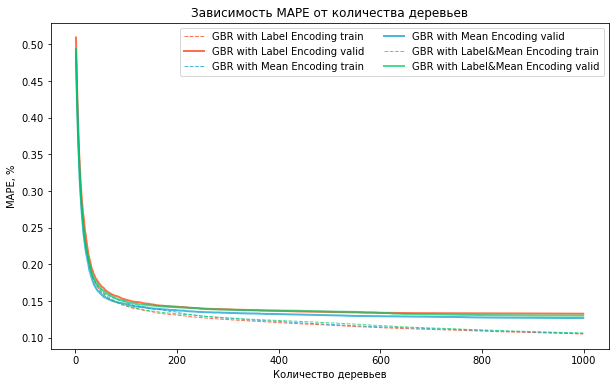

In [332]:
plot_dependence_test(
    param_grid=n_estimators_grid, 
    mape_train=mape_train, 
    mape_valid=mape_valid,
    descr=['GBR with Label Encoding', 'GBR with Mean Encoding', 'GBR with Label&Mean Encoding'],
    param_label='Количество деревьев', 
    title='Зависимость MAPE от количества деревьев',
    ylim=None
)

*Оба типа энкодинга дает почти одинаковые результаты, MeanEncoding - незначительно лучше. В обоих случаях с ростом количества деревьев качество улучшается, причем не наблюдается переобучения.*

*Для смеси энкодингов результаты получились аналогичные, чуть хуже чем в случае когда все категориальные признаки кодировались с помощью MeanEncoding*

In [337]:
max_depth_grid = np.arange(2, 16)
mape_train, mape_valid = [], []
mape_train1, mape_valid1 = [], []
mape_train2, mape_valid2 = [], []

for max_depth in max_depth_grid:
    regressor = GradientBoostingRegressor(max_depth=max_depth)
    regressor.fit(X_train_le, y_train_le)
    mape_train.append(mean_absolute_percentage_error(y_train_le, regressor.predict(X_train_le)))
    mape_valid.append(mean_absolute_percentage_error(y_valid_le, regressor.predict(X_valid_le)))
    
    regressor.fit(X_train_me, y_train_me)
    mape_train1.append(mean_absolute_percentage_error(y_train_me, regressor.predict(X_train_me)))
    mape_valid1.append(mean_absolute_percentage_error(y_valid_me, regressor.predict(X_valid_me)))
    
    regressor.fit(X_train_mle, y_train_mle)
    mape_train2.append(mean_absolute_percentage_error(y_train_mle, regressor.predict(X_train_mle)))
    mape_valid2.append(mean_absolute_percentage_error(y_valid_mle, regressor.predict(X_valid_mle)))

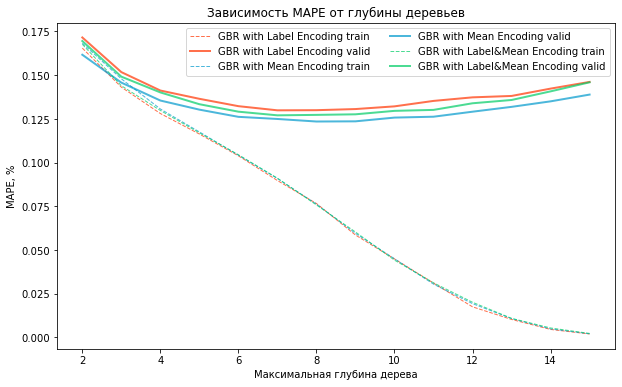

In [338]:
plot_dependence_test(
    param_grid=max_depth_grid, 
    mape_train=[mape_train, mape_train1, mape_train2], 
    mape_valid=[mape_valid, mape_valid1, mape_valid2],
    descr=['GBR with Label Encoding', 'GBR with Mean Encoding', 'GBR with Label&Mean Encoding'],
    param_label='Максимальная глубина дерева', 
    title='Зависимость MAPE от глубины деревьев',
    ylim=None
)

In [354]:
np.argmin(mape_valid) + 1, np.argmin(mape_valid1) + 1, np.argmin(mape_valid2) + 1

(6, 7, 6)

*Оптимальная глубина по валидационной выборке в случае LabelEcoding - 6, MeanEncoding - 7. По трэйну в обоих случаях видно, что модель начинает переобучаться с увеличением глубины дерева.*

**Выводы:**

*В данном случае у меня получилось, что бустиги, обученные на данных, предобработанных с LabelEncoding и MeanEncoding, дают примерно одинаковую ошибку, но результат с MeanEncoding - чуть лучше. Скорее всего, так произошло потому что все категориальные признаки имеют не сликшом большое количество категорий, самые большие - в районе 10 значений. Видимо, результаты отличались бы значительнее, если бы сравнивалось кодирование признака с большим количеством категорий.*

---

### Задача 2

Возьмите свое решение задачи 3.8.3. Если его нет, то решение задачи 3.8.2.

Задача состоит в том, чтобы попробовать улучшить предсказание вашей модели с помощью извлечения различных признаков с использованием кластеризации объектов. 

*Примечание.* Если предлагаемые преобразования уже были в вашем решении, в этой задаче обучите аналогичную модель без данных преобразований и сравните результаты с исходной моделью.

Общая схема следующая:
* кластеризация всех объектов на несколько кластеров, например, используя только широту и долготу;
* создание новых признаков &mdash; расстояние от объекта до центра кластера, а также средних характеристик по кластерам, например, количество комнат в квартире в среднем по кластеру;
* обучение модели с добавлением новых признаков.

Прежде чем приступить к выполнению, ответьте на следующие вопросы из логических соображений.
* Какой метод кластеризации стоит использовать и почему?
* Имеет ли смысл выполнять кластеризацию по другим признакам, помимо широты и долготы?
* Какие новые признаки добавить?
* Как могут повлиять новые признаки на конкретно вашу модель?

- Думаю что тут стоит брать DBScan, так как кластеры расположены плотно и формы сложные. Но так как кластеризуем по координатам, должен также подойти Kmeans как метрический метод. 
- Я могу придумать такую кластеризацию: по возрасту дома, ремонту и общей оценке - это будут кластеры по общему состоянию дома. Каких-то других осмысленных придумать пока не могу.
- Средняя цена дома по zipcode, средняя цена за квадратный метр по zipcode, вместо даты постройки взять возраст дома, как давно делался ремонт, признаки, умноженные на площадь жилья и площадь участка.
- Новые признаки должны повысить качество, так как в моей исходной модели довольно мало работы с признаками, новых почти не было создано.

Выполните предобработку данных, которая уже была в вашем решении.

Комментарий
1. В исходной предобработке я сразу убирала признаки 'sqft_above', 'sqft_basement' - это было не совсем верно. Нужно оставить 2 признака из 3х, чтобы избавиться от линейной зависимости. Также на их основе можно сделать другие признаки
2. Также я сразу убирала признаки 'sqft_living15', 'sqft_lot15', сейчас попробую оставить и сделать на их основе другие признаки
3. Также попробую не избавляться от крайних значений, они могут быть важны в модели
4. Остальные предобработки оставлю, сделав их в первую очередь

Выполните извлечение признаков, не забывая подробно комментрировать каждый этап.

In [663]:
data = pd.read_csv('../градиентный бустинг/houses_train.csv')

*Исходная предобработка*

In [664]:
def transform_data_initial(data):
    data.drop(['id', 'sqft_above'], axis=1, inplace=True)
    data['renovated'] = data['yr_renovated'].apply(lambda x : 0 if x == 0 else 1)
    data['date'] = data.loc[:, 'date'].apply(lambda d: int(d[:4]))
    data['yr_built'] = data.loc[:, 'yr_built'].apply(lambda d: int(d))
    data['bathrooms'] = data.loc[:, 'bathrooms'].apply(lambda n: int(round(n)))
    data['floors'] = data.loc[:, 'floors'].apply(lambda n: int(round(n)))

transform_data_initial(data)

*Кластеризация. Гиперпараметры подберу по метрике коэффициент силуэта*

In [412]:
data_coords = data[['lat', 'long']]

In [553]:
param_dbscan = {
    'eps': np.linspace(0.01, 0.1, 10),
    'min_samples': np.linspace(30, 40, 10)
}
gs = GridSearchCV(DBSCAN(), 
                  param_dbscan,
                  scoring=silhouette_score)
gs.fit(data_coords)

GridSearchCV(estimator=DBSCAN(),
             param_grid={'eps': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'min_samples': array([30.        , 31.11111111, 32.22222222, 33.33333333, 34.44444444,
       35.55555556, 36.66666667, 37.77777778, 38.88888889, 40.        ])},
             scoring=<function silhouette_score at 0x7fb493e8aca0>)

In [556]:
y_pred = gs.best_estimator_.fit_predict(data_coords)
outliers = (y_pred == -1)

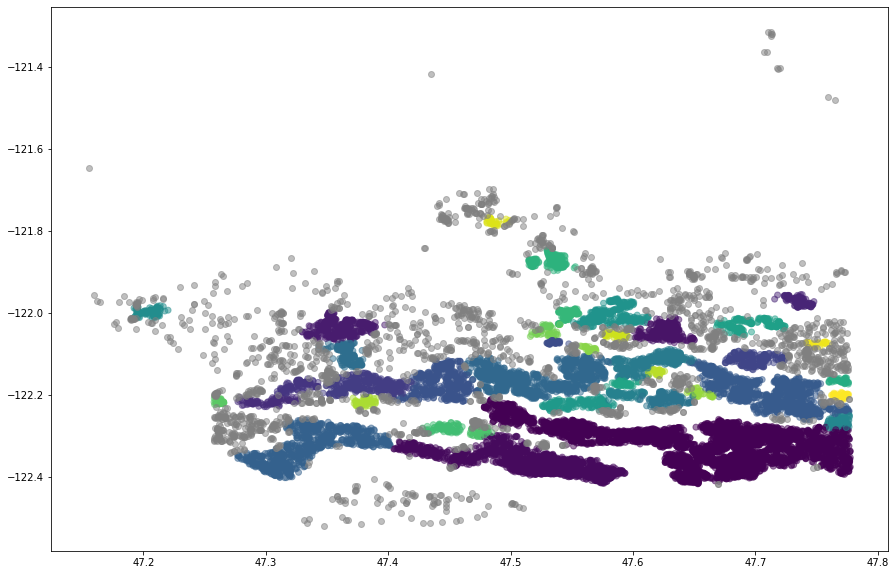

In [567]:
plt.figure(figsize=(15, 10))

plt.scatter(data_coords.iloc[~outliers, 0], data_coords.iloc[~outliers, 1], 
            c=y_pred[~outliers], alpha=0.5)
plt.scatter(data_coords.iloc[outliers, 0], data_coords.iloc[outliers, 1], 
            c='gray', alpha=0.5);

*Кластеризация получилась не очень хорошая - много точек считаются шумом. Попробую Kmean, аналогично подбирая гиперпараметр количества кластеров по коэф-ту силуэта*

In [639]:
silhouette_scores = []

for k in range(2, 100):
    model = KMeans(n_clusters=k, n_jobs=-1)
    model.fit(data_coords)
    pred = model.predict(data_coords)
    silhouette_scores.append(silhouette_score(data_coords, pred))

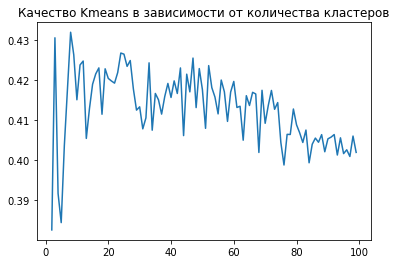

In [641]:
plt.plot(range(2, 100), silhouette_scores)
plt.title('Качество Kmeans в зависимости от количества кластеров');

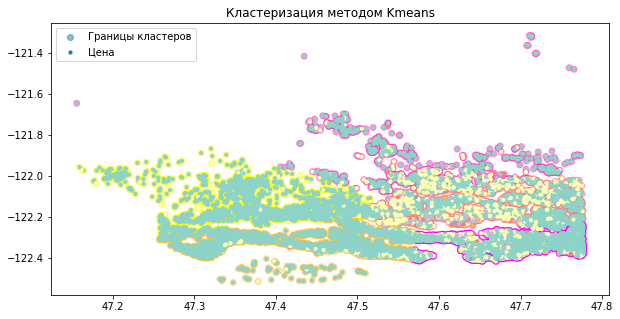

In [643]:
pred = KMeans(n_clusters=5).fit_predict(data_coords)

plt.figure(figsize=(10, 5))
plt.scatter(data_coords.lat, data_coords.long, c=pred, alpha=0.5, 
            cmap='spring', label='Границы кластеров')
plt.scatter(data.lat, data.long, s=10, c=data.price, cmap='Set3', alpha=1, 
            label='Цена')
plt.legend()
plt.title('Кластеризация методом Kmeans');

*Область с максимальной коцентрацией самых дорогих домов (светло-желтые и оранжевые точки) содержится в преимущественно в одном кластере. В целом, не очень информативная кластеризация, так что помимо нее еще добавлю группировку по zipcode*

In [665]:
def transform_data_additional(data):
    # преобразования
    data['coord_cluster'] = pred
    prices_by_zipcode = dict(data.groupby(['zipcode']).mean()['price'])
    data['price_per_meter'] = data['price'] / data['sqft_living']
    prices_per_meter_by_zipcode = dict(data.groupby(['zipcode']).mean()['price_per_meter'])
    data['prices_by_zipcode'] = data['zipcode'].map(prices_by_zipcode)
    data['prices_per_meter_by_zipcode'] = data['zipcode'].map(prices_per_meter_by_zipcode)
    
    data = data.drop(['zipcode'], axis=1)

    # даты
    data['age'] = data['date'] - data['yr_built']
    data.loc[data['yr_renovated'] == 0, 'yr_renovated'] = data['yr_built']
    data['years_from_renovation'] = data['date'] - data['yr_renovated']
    data['year_sold'] = pd.to_datetime(data['date']).dt.year
    data = data.drop(['date', 'yr_built', 'yr_renovated'], axis=1)

    
    # новые признаки
    data['basement_percentage'] = data['sqft_basement'] / data['sqft_living']
    data['compare_to_neighbour_sqft_living'] = data['sqft_living'] / data['sqft_living15']
    data['compare_to_neighbour_sqft_lot'] = data['sqft_lot'] / data['sqft_lot15']
    data['mean_room_sqft'] = data['sqft_living'] / data['bedrooms']
    
    # все признаки, увеличенные пропорционально площади дома
    for feature in ['bedrooms', 'bathrooms', 
                'floors',
                'waterfront', 'view',
                'condition', 'grade',
                'sqft_living15', 'sqft_lot15',
                'prices_by_zipcode', 'prices_per_meter_by_zipcode',
                'age', 'renovated', 'years_from_renovation'] + \
        ['condition', 'bedrooms', 'bathrooms', 'floors', 'grade']:
        data[feature + '_dot_sqft_living'] = data[feature] * data['sqft_living']
        data[feature + '_dot_sqft_lot'] = data[feature] * data['sqft_lot']
    
    return data

In [666]:
transform_data_additional(data)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,prices_by_zipcode_dot_sqft_living,prices_by_zipcode_dot_sqft_lot,prices_per_meter_by_zipcode_dot_sqft_living,prices_per_meter_by_zipcode_dot_sqft_lot,age_dot_sqft_living,age_dot_sqft_lot,renovated_dot_sqft_living,renovated_dot_sqft_lot,years_from_renovation_dot_sqft_living,years_from_renovation_dot_sqft_lot
0,221900.0,3,1,1180,5650,1,0,0,3,7,...,3.749134e+08,1.795136e+09,225428.932683,1.079384e+06,70800,339000,0,0,70800,339000
1,538000.0,3,2,2570,7242,2,0,0,3,7,...,1.213204e+09,3.418685e+09,736136.870943,2.074359e+06,164480,463488,2570,7242,61680,173808
2,604000.0,4,3,1960,5000,1,0,0,5,7,...,1.059507e+09,2.702824e+09,667337.481251,1.702392e+06,98000,250000,0,0,98000,250000
3,510000.0,3,2,1680,8080,1,0,0,3,8,...,1.164173e+09,5.599116e+09,445241.149809,2.141398e+06,48720,234320,0,0,48720,234320
4,257500.0,3,2,1715,6819,2,0,0,3,7,...,5.080436e+08,2.020029e+09,269913.067851,1.073200e+06,34300,136380,0,0,34300,136380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2,1490,1126,3,0,0,3,8,...,8.793245e+08,6.645096e+08,463918.958829,3.505857e+05,2980,2252,0,0,2980,2252
15622,610685.0,4,2,2520,6023,2,0,0,3,9,...,1.058880e+09,2.530807e+09,544681.593143,1.301832e+06,2520,6023,0,0,2520,6023
15623,360000.0,3,2,1530,1131,3,0,0,3,8,...,8.903474e+08,6.581588e+08,562493.625450,4.158041e+05,9180,6786,0,0,9180,6786
15624,400000.0,4,2,2310,5813,2,0,0,3,8,...,8.393604e+08,2.112209e+09,530849.090988,1.335855e+06,4620,11626,0,0,4620,11626


Обучите модель по новым признакам.

In [667]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, shuffle=True, random_state=17
)

*Возьму модель XGBoost с параметрами, подобранными в предущем задании для изначальных преобразований, чтобы корректно сравнить результаты*

In [671]:
params = {'alpha': 0.28, 'lambda': 10.0, 'n_estimators': 467, 'max_depth': 6, 
          'min_child_weight': 4, 'colsample_bytree': 0.8, 'subsample': 0.8,
          'gamma': 0, 'learning_rate': 0.1, 'eval_metric': 'mape'}

model = XGBRegressor(**params)
model.fit(X_train, y_train)
mean_absolute_percentage_error(model.predict(X_test), y_test)

0.020160101538799532

Удалось ли повысить качество? Если да, то является ли улучшение статистически значимым?

*Качество значительно повысилось! В прошлом задании было MAPE=11.8%, сейчас - 2%.*

**Выводы:** *Правильная предобработка признаков и создание новых могут значительно повысить качество модели. Очень важно это делать.*

---

### Задача 3

Рассмотрим одну из уже классических задач машинного обучения — предсказание кредитного рейтинга клиентов кредитной организации. В данной задаче вам нужно провести анализ данных, построить классификатор клиентов и отправить свои предсказания в Kaggle-соревнование.

Кредитный скоринг — система оценки кредитоспособности (кредитных рисков) потенциальных и действующих клиентов, в основу которой вкладываются статистические данные. Кредитный скоринг широко используется как крупными банками, микрофинансовыми организациями, так и в потребительском (магазинном) экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой автоматически принимается решение об одобрении или отказе в выдаче кредита.

Описание данных:
* `client_id`: уникальный идентификатор клиента;
* `month`: месяц сбора информации;
* `age`: возраст клиента;
* `occupation`: вид деятельность;
* `annual_income`: годовой доход;
* `monthly_salary`: зарплата за текущий месяц;
* `number_bank_accounts`: количество банковских счетов у данного клиента;
* `number_credit_cards`: количество кредитных карт у данного клиента;
* `interest_rate`: процентная ставка по кредитной карте;
* `number_loan`: количество кредитов, взятых в банке;
* `delay_from_due_date`: среднее количество дней задержки выплат по кредиту;
* `number_delayed_payment`: количество платежей по кредиту, которые были выполнены с задержкой;
* `number_credit_inquiries`: количество запросов по кредиту;
* `unpaid_debt`: сумма долга;
* `credit_utilization_ratio`: коэффициент использования кредитных карт;
* `credit_history_age`: размер кредитной истории;
* `min_amount_payment`: была ли произведенная выплата минимально возможной;
* `monthy_amount_invested`: сумма инвестиций за месяц;
* `client_behaviour`: платежное поведение клиента;
* `monthly_balance`: баланс по итогу месяца;
* `credit_rating`: кредитный рейтинг — это **целевой признак**.

Ссылка: https://www.kaggle.com/competitions/ds-2022-autumn-39/overview

Инвайт: https://www.kaggle.com/t/6c00aded7dfc4cf181c3727b2ca995bf

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике Accuracy.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard.
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки. Если будет необходимость перевода соревнования в Яндекс.Контест, то только одну, причем она должна быть последней.
* В Leaderboard должны отображаться ваши **реальные имя и фамилия**. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения. **Это будет проверяться.**
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Не забывайте сделать пояснения к своему решению. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 
* Изучите различные методы, предложенные на занятиях.

**Баллы**

* **Выдаются только при соблюдении всех правил** и суммируются.
* 10 баллов — ваше решение лучше sample_submission.csv на Private Leaderboard.
* по 15 баллов — за каждый следующий преодоленный порог на Private Leaderboard, пороги: 55%, 65%, 75%, 85%.
* 20 баллов за попадание в топ-3 на Private Leaderboard.
* 1 конфета — попадание в топ-10 на Private Leaderboard.
* 1 средняя конфета — попадание в топ-3 на Private Leaderboard.
* 1 большая конфета — попадание в топ-1 на Private Leaderboard.
* небольшие декоративные фигурки за топ-1 на Private Leaderboard, за наиболее хорошо оформленное решение, за самую оригинальную идею (которая привела к улучшению).

## *В отдельном файле*